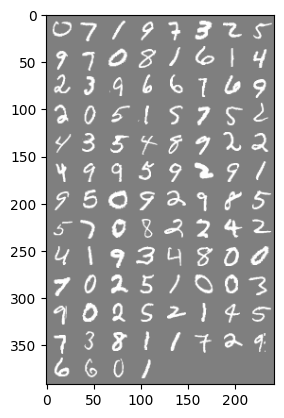

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# config device
device = torch.device('cpu')

# hyper-parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/', train=True, transform=transforms.ToTensor(),
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='../../data/', train=False, transform=transforms.ToTensor())

# Data load
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# function to show an image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images from dataset
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
# show images
imshow(torchvision.utils.make_grid(images))

In [5]:
# CNN(two layer)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), #inChannels, outChannels, kernel_size, stride, padding
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimize
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.1064
Epoch [1/5], Step [200/600], Loss: 0.1461
Epoch [1/5], Step [300/600], Loss: 0.0572
Epoch [1/5], Step [400/600], Loss: 0.0417
Epoch [1/5], Step [500/600], Loss: 0.0197
Epoch [1/5], Step [600/600], Loss: 0.0698
Epoch [2/5], Step [100/600], Loss: 0.0693
Epoch [2/5], Step [200/600], Loss: 0.0885
Epoch [2/5], Step [300/600], Loss: 0.0683
Epoch [2/5], Step [400/600], Loss: 0.0173
Epoch [2/5], Step [500/600], Loss: 0.0163
Epoch [2/5], Step [600/600], Loss: 0.0183
Epoch [3/5], Step [100/600], Loss: 0.0094
Epoch [3/5], Step [200/600], Loss: 0.0276
Epoch [3/5], Step [300/600], Loss: 0.0254
Epoch [3/5], Step [400/600], Loss: 0.0359
Epoch [3/5], Step [500/600], Loss: 0.0108
Epoch [3/5], Step [600/600], Loss: 0.0044
Epoch [4/5], Step [100/600], Loss: 0.0736
Epoch [4/5], Step [200/600], Loss: 0.0333
Epoch [4/5], Step [300/600], Loss: 0.0403
Epoch [4/5], Step [400/600], Loss: 0.0120
Epoch [4/5], Step [500/600], Loss: 0.0307
Epoch [4/5], Step [600/600], Loss:

Model Accuracy on the 10000 test images: 98.98 %


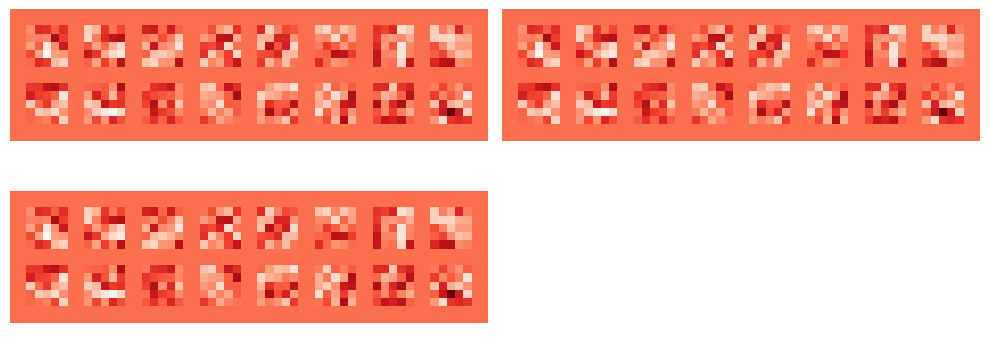

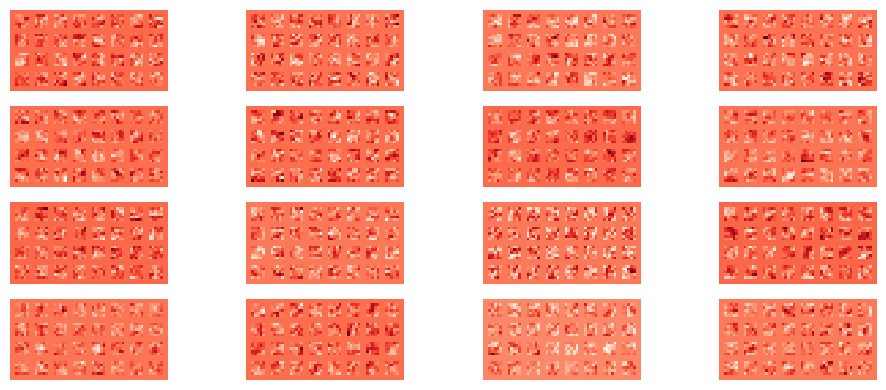

Predicted Label is 7


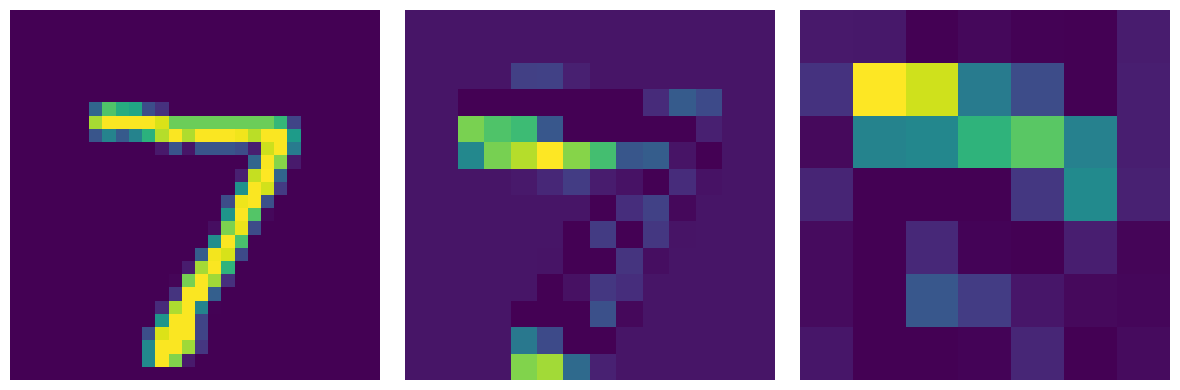

In [19]:
from torchvision import utils
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Model Accuracy on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'testModel.ckpt')

#Visualize filters
def visTensor(filter):
    weight = utils.make_grid(filter.weight.data).numpy()
    channels=weight.shape[0]
    if(channels%3==0):
        cols = 3
    if(channels%4==0):
        cols= 4
    else:
        cols=2

    rows = -(-channels // cols)  # Ceiling division to get the number of rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4))  # Create a grid of subplots
    fig.patch.set_facecolor('white')  # Set the facecolor for the entire figure
    
    for i, ax in enumerate(axes.flat):
        if i < channels:
            ax.imshow(weight[i], cmap='Reds', interpolation='nearest')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes for empty subplots

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

visTensor(model.layer1[0])
visTensor(model.layer2[0])

# Plot feature map (to adjust based on number of layer)
model.eval()
with torch.no_grad():
    images, labels = iter(test_loader).__next__()
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted Label is {}'.format(predicted[0]))
    image_list = [
    images[0][0].cpu().numpy(),
    model.layer1(images)[0][0].cpu().numpy(),
    model.layer2(model.layer1(images))[0][0].cpu().numpy()
    #insert layer
    ]

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(image_list[i])
    ax.axis('off')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
